In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import Counter
import re
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import calendar
import ics
from collections import defaultdict
import arrow

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
def read_facebook_timeline_data():
    """
    This function reads in the appropriate html file for timeline information
    """
    with open('./timeline.htm') as f:
        soup = BeautifulSoup(f, "lxml")
    return soup

In [4]:
def read_twitter():
    tweets_csv = pd.read_csv('tweets.csv')
    return tweets_csv

In [5]:
def read_safely(path):
  error = None
  try:
    con_df = pd.read_csv(path,encoding = "ISO-8859-1")
    return con_df
  except FileNotFoundError as err:
    print("File %s does not exist. Try again." % path)

In [6]:
def clean_timeline():
    """
    Calls the read_facebook_timeline_data function, and then strips 
    data of all html tags. Once done this creates the information for 
    usage across days of the week, month of the year and year.
    """
    soup = read_facebook_timeline_data()
    timeline_info = soup.find_all("div", class_ = 'meta')
    clean_timeline = []
    for i in timeline_info:
        clean_timeline.append(re.sub(r'<.+?>', '', str(i)))
    clean_new_timeline = []
    for i in clean_timeline:
        clean_new_timeline.append([x.strip() for x in i.split(',')])
    days_information = [item[0] for item in clean_new_timeline]
    days = dict(Counter(days_information))
    list_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for k in list_of_days:
        if k not in days:
            days[k] = 0
        else:
            pass
    days = pd.DataFrame.from_dict(days, orient = 'index').reset_index().rename(columns = {'index': 'Days', 0:'Count'})
    date_information = [item[1] for item in clean_new_timeline]
    clean_new_date = []
    for i in date_information:
        clean_new_date.append([x.strip() for x in i.split('at')])
    date_information = [item[0] for item in clean_new_date]
    date = pd.DataFrame(np.array(date_information), columns= {'Date'})
    date['Date'] = pd.to_datetime(date['Date'])
    month = date['Date'].groupby([date.Date.dt.month]).agg('count')
    month = pd.DataFrame(month).rename(columns = {'Date': 'Count'}).reset_index()
    month['Date'] = month['Date'].apply(lambda x: calendar.month_abbr[x])
    year = date['Date'].groupby(date.Date.dt.year).agg('count')
    year = pd.DataFrame(year).rename(columns = {'Date': 'Count'}).reset_index()
    return days, month, year, date

In [47]:
def make_month(df,date_column,flag):
    df['date'] = pd.to_datetime(df[date_column]).dt.date
    df['year'] = pd.to_datetime(df[date_column]).dt.year
    df['month'] = pd.to_datetime(df[date_column]).dt.month
    df_new = df[['date','year','month']]
    if flag == 'T':
        col = 'twitter-count'
    if flag == 'L':
        col = 'ln-count'
    if flag == 'F':
        col = 'fb-count'
    if flag == 'G':
        col = 'cal-count'
    df_new[col]=df_new['year'].apply(str)+'-'+df_new['month'].apply(str)
    df_new[col]=pd.DatetimeIndex(df_new[col],frequency = 'D')
    df_new = df_new[[col]]
    df_new = df_new[col].value_counts().reset_index()
    return df_new

In [54]:
def plot_crossds(joined_df):
    plt.style.use('seaborn-darkgrid')
    fig,ax= plt.subplots(nrows=1)
    ax.plot(joined_df['index'],joined_df['twitter-count'],label = 'Twitter Activity',color = '#1DA1F2',linewidth=2,alpha = 0.7)
    ax.plot(joined_df['index'],joined_df['ln-count'], label = 'LinkedIn Activity',color = '#8D6CAB',linewidth=2,alpha = 0.7)
    ax.plot(joined_df['index'],joined_df['fb-count'], label = 'Facebook Activity',color = '#3b5998',linewidth=2,alpha = 0.7)
    ax.plot(joined_df['index'],joined_df['cal-count'], label = 'Calender Activity',color = '#db3236',linewidth=2,alpha = 0.7)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(loc='upper right', prop={'size': 20})
    plt.yticks(fontsize=16,fontstyle='italic')
    plt.xticks(fontsize=16,fontstyle='italic')
    ax.set_xlabel('Year-Month',fontsize=18)
    ax.set_ylabel('Activity Count',fontsize=18)
    ax.set_title('Social Media Activity by Year-Month',fontsize=24,fontweight='bold')
    fig.set_size_inches(15,10)
    return

In [31]:
def _process_calendar(calendar_file):
    """Processes a calendar, grouping events by name.
    Args:
        calendar_file: the ics calendar file
        start_date: the starting date, or None
        end_date: the end date, or None
        allday: if true, includes all day events in processing
        grouping_regex_strs: regular expressions for grouping patterns
    """
    print("Calendar file name", calendar_file)
    calendar = ics.Calendar(open(calendar_file).read())
    cal_df = pd.DataFrame(columns=['day', 'month', 'year', 'hour', 'event_name', 'duration'])
    groups = defaultdict(lambda: 0)
    total_seconds = 0
    i = 0
    for event in calendar.events:
        start_date = arrow.get(event.begin)
        end_date = arrow.get(event.end)
        cal_df.loc[i] = [start_date.datetime.day, start_date.datetime.month, start_date.datetime.year,
                         start_date.datetime.hour,
                         event.name, event.duration.total_seconds()]
        i += 1


    return cal_df

In [42]:
def get_cal_dates(cal_df):
    cal_dates = pd.DataFrame(columns=['Date','count'])
    cal_dates['Date']  = pd.to_datetime(cal_df[['day','month','year']])
    cal_dates['count']=1
    return cal_dates

## Read Data

In [9]:
tweets_df = read_twitter()

In [10]:
con_df = read_safely('./connections.csv')

In [11]:
days, month, year, fb_df = clean_timeline()

In [33]:
cal_df_full = _process_calendar('./shsher@uw.edu.ics')

Calendar file name ./shsher@uw.edu.ics


In [43]:
cal_df = get_cal_dates(cal_df_full)

In [44]:
cal_df.head()

,Date,count
0,2016-01-01,1
1,2016-03-18,1
2,2016-04-01,1
3,2016-05-03,1
4,2016-06-04,1


## Make dataframe by Year-Month on each Dataset

In [12]:
tweets_df_month = make_month(tweets_df,'timestamp','T')

In [13]:
conn_df_month = make_month(con_df,'Connected On','L')

In [14]:
fb_df_month = make_month(fb_df,'Date','F')

In [48]:
gcal_df_month = make_month(cal_df,'Date','G')

In [49]:
# joined_df = tweets_df_new.merge(conn_df_new, left_on='index', right_on='index', how='outer').sort_values(by='index')
joined_df = tweets_df_month.merge(conn_df_month, left_on='index', right_on='index', how='outer').\
            merge(fb_df_month, left_on='index', right_on='index', how='outer').\
            merge(gcal_df_month, left_on='index', right_on='index', how='outer').sort_values(by='index').fillna(0)

In [55]:
plot_crossds(joined_df)

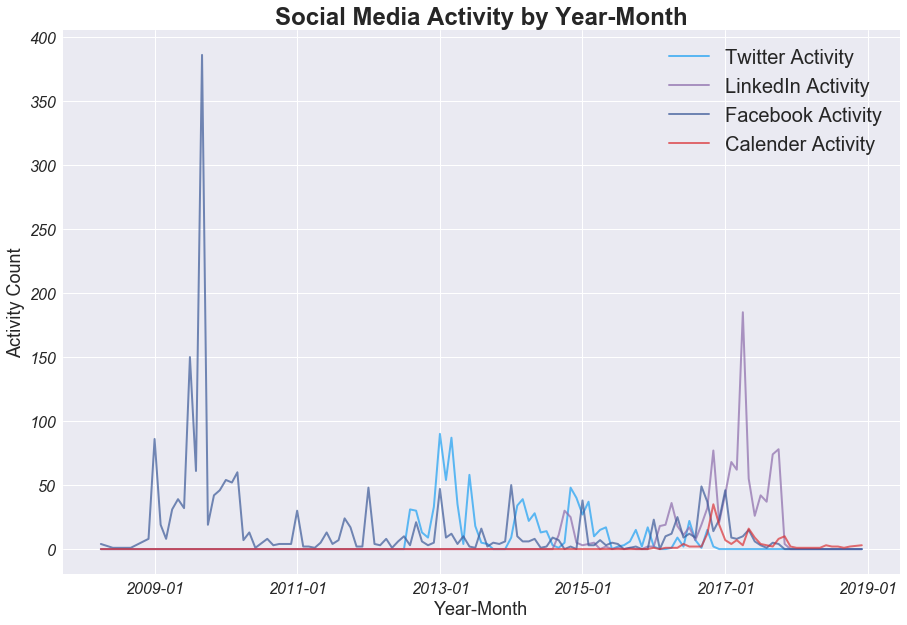

In [56]:
plt.show()